# Neural network with two hidden layers

In this notebook I will implement a neural network with two hidden layers which serves as a binary planar classifier . This was inspired by the course on Neural Networks and Deep Learning by deeplearning.ai and serves as a way to cement my understanding by implementing a slightly different architecture than that in the course without using tensorflow or pytorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn
import sklearn.datasets
import sklearn.linear_model

## 0) The dataset

The neural network we will build will be trained on a labelled dataset $Dataset=(X, Y)$ where $(x_1,x_2)\in X$ are some points in the plane and $y\in Y$ are the labels ($0$ Red or $1$ Blue). We will attempt to train the classifier on the three following datasets:
1. $X$ are some points in the unit square and $Y$ is whether the point lies below the line $x_1=x_2$.
2. $X$ are some points in the unit square and $Y$ is whether the point lies inside the circle $x_1^2+x_2^2=1$.
3. $X$ are some points in the plane and $Y$ is whether the point lies in the first or third quadrants.

All the datasets will use contain $800$ training examples and $200$ verification examples.

In [2]:
def generate_dataset(dataset='line'):
    
    np.random.seed(1)
    
    if dataset == 'line':
        X = np.random.rand(800,2) 
        Y = np.array([[int(x[1]>x[0]) for x in X]]).T
        X_ver = np.random.rand(200,2)
        Y_ver = np.array([[int(x[1]>x[0]) for x in X_ver]]).T
        
    elif dataset == 'disk':
        X = np.random.rand(800,2)
        Y = np.array([[int(x[0]**2+x[1]**2<1) for x in X]]).T
        X_ver = np.random.rand(200,2)
        Y_ver = np.array([[int(x[0]**2+x[1]**2<1) for x in X_ver]]).T
    
    elif dataset == 'quadrants':
        X = np.ones((800,2))-2*np.random.rand(800,2)
        Y = np.array([[int(x[1]*x[0]>0) for x in X]]).T
        X_ver = np.ones((200,2))-2*np.random.rand(200,2)
        Y_ver = np.array([[int((x[1]*x[0]>0)) for x in X_ver]]).T
    
    else:
        print("Dataset unrecognized. Defaulting to dataset 1")
        X = np.random.rand(800,2)
        Y = np.array([[int(x[1]>x[0]) for x in X]]).T
        X_ver = np.random.rand(200,2)
        Y_ver = np.array([[int(x[1]>x[0]) for x in X_ver]]).T
    
    return X, Y, X_ver, Y_ver
        
    
        

We can visualize the different datasets and see that they coincide with our expectations:

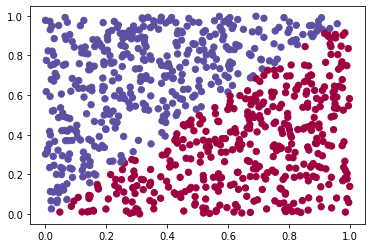

In [3]:
X, Y, X_ver, Y_ver = generate_dataset('line')
# Visualize the data:
plt.scatter(X[:, 0], X[:, 1], c = Y, s=40, cmap=plt.cm.Spectral);

While we will only use these datasets throughout this notebook, any labelled planar dataset should work fine.

## 1) Performance of logistic regression

Before we build our neural network, let's see how a simple logistic regression performs on the three datasets.

In [4]:
# This helper code was copied from deeplearning.ai course on Neural Networks and Deep Learning and is 
# used for visualising the decision boundaries.
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

Accuracy of logistic regression: 94 % (percentage of correctly labelled datapoints)


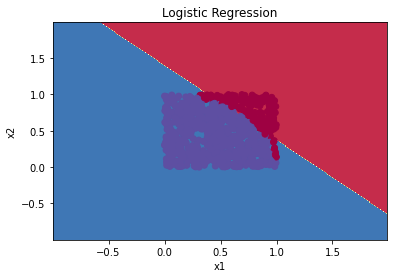

In [5]:
X, Y, X_ver, Y_ver = generate_dataset('disk')

# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X, np.ravel(Y.T)); #Y has shape (800,1) while clf requires a shape of the form (M,)

plot_decision_boundary(lambda x: clf.predict(x), X.T, Y)
plt.title("Logistic Regression")

LR_predictions = clf.predict(X_ver)

print ('Accuracy of logistic regression: %d ' % float((np.dot(Y_ver.T,LR_predictions) + np.dot(1-Y_ver.T,1-LR_predictions))/float(Y_ver.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

We can see that Linear regression has a $100%$ accuracy on the first dataset since it is linearly separable, a $94%$ accuracy on the second dataset, and a mere $54%$ accuracy on the third dataset as it is not close to being linearly separable.

We will now move on to building our neural network and see how well it performs on these datasets.

## 2) The Neural Network implementation

We will begin by choosing the appropriate layer sizes and initializing the parameters we will train. Then we will choose the activation functions and implement forward and backward propagation. 

For our purposes we could have hardcoded the layer dimensions, but in view of possible generalization, we opt to provide a NN capable of working with other datasets.

In [6]:
def layer_sizes(X, Y, n_1 = 5, n_2 = 4):
    """
    Arguments:
    X -- input dataset 
    Y -- labels 
    n_1 -- the size of the first hidden layer
    n_2 -- the size of the second hidden layer
    
    Returns:
    n_x -- size of the input layer
    n_1 -- the size of the first hidden layer
    n_2 -- the size of the second hidden layer
    n_y -- size of the output layer
    """
    n_x = X.shape[1] 
    n_y = Y.shape[1]
    
    return (n_x, n_1, n_2, n_y)

For our datasets this returns $(2,5,4,1)$ as $X$ has two features/dimensions and $Y$ has a single feature.

Our next step is to initialize the weights and biases of our Neural network given the size of its layer dimensions. We will do so randomly for the weights and set the bias vectors to $0$.

In [7]:
def initialize_parameters(n_x, n_1, n_2, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_1 -- size of the first hidden layer
    n_2 -- size of the second hidden layer
    n_y -- size of the output layer
    
    Returns:
    weights_biases -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_1, n_x)
                    b1 -- bias vector of shape (n_1, 1)
                    W2 -- weight matrix of shape (n_2, n_1)
                    b2 -- bias vector of shape (n_2, 1)
                    W3 -- weight matrix of shape (n_y, n_2)
                    b3 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(2) 
    
    W1 = np.random.rand(n_1, n_x)
    b1 = np.zeros((n_1,1))
    W2 = np.random.rand(n_2, n_1)
    b2 = np.zeros((n_2,1))
    W3 = np.random.rand(n_y, n_2)
    b3 = np.zeros((n_y,1))
    
    weights_biases = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return weights_biases

Our next step is to deefine forward and backward propagation. We will use a sigmoid activation in the final layer, a tanh activation in the first layer and a Leaky ReLu activation in the second layer.

In [8]:
def sigmoid(z):
    return(1/(1+np.exp(-z)))
def dsigmoid(z):
    return(z*(1-z))
def Leak_ReLu(z):
    return (z * ((z > 0) + 0.05))
def dLeak_Relu(z):
    return (1 * (z > 0) + 0.05)

In [12]:
def forward_propagation(X, weights_biases):
    """
    Argument:
    X -- input data of size (m, n_x)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A3 -- The sigmoid output of the third activation
    cache -- a dictionary containing "Z1", "A1", "Z2", "A2", "Z3" and "A3"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = weights_biases['W1']
    b1 = weights_biases['b1']
    W2 = weights_biases['W2']
    b2 = weights_biases['b2']
    W3 = weights_biases['W3']
    b3 = weights_biases['b3']
    
    # Implement Forward Propagation to calculate A3 (probabilities)
    Z1 = W1@X.T+b1
    A1 = np.tanh(Z1)
    Z2 = W2@A1+b2
    A2 = Leak_ReLu(Z2)
    Z3 = W3@A2+b3
    A3 = sigmoid(Z3)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2,
             "Z3": Z3,
             "A3": A3}
    
    return(A3, cache)

Having computed $A^{[3]}$ we can now compute the cross-entropy loss cost function $$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[3] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[3] (i)}\right) \large{)},$$

In [115]:
def loss(A3, Y, weights_biases):
    """
    Computes the cross-entropy cost given in equation 
    
    Arguments:
    A3 -- The sigmoid output of the third activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    weights_biases -- python dictionary containing your parameters W1, b1, W2, b2, W3 and b3. 
    
    Returns:
    cost -- cross-entropy cost 
    """
    
    m = Y.shape[0] # number of example
    logprobs = np.multiply(np.log(A3+0.00001),Y.T)+np.multiply(np.log(1-A3+0.00001),1-Y.T) #we add 0.00001 to avoid log(0)
    cost = -1/m * np.sum(logprobs)
    
    loss = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    
    return loss

Our next step is implementing the backpropagation algorithm. We have already written the derivatives of the Leaky ReLU and the Sigmoid activation function, while for $d \tanh(z)$ we use the observation that $a=\tanh(z)$ implies $d\tanh(z) = 1 - a^2$

In [116]:
def backward_propagation(weights_biases, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    weights_biases -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2", "A2", "Z3" and "A3".
    X -- input data of shape (number of examples, 2)
    Y -- "true" labels vector of shape (number of examples, 1)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[0]
    
    # First, retrieve W1, W2, W3 from the dictionary "weights_biases".
    W1 = weights_biases["W1"]
    W2 = weights_biases["W2"]
    W3 = weights_biases["W3"]

    # Retrieve also A1, A2, A3 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    A3 = cache["A3"]
    Z2 = cache["Z2"]

    
    # Backward propagation: calculate dW1, db1, dW2, db2, dW3, db3
    dZ3 = A3 - Y.T
    dW3 = 1/m * dZ3 @ A2.T 
    db3 = 1/m * np.sum(dZ3, axis = 1, keepdims = True)
    dZ2 = W3.T @ dZ3 * dLeak_Relu(Z2)
    dW2 = 1/m * dZ2 @ A1.T
    db2 = 1/m * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = W2.T @ dZ2 * (1-A1**2)   
    dW1 = 1/m * dZ1 @ X
    db1 = 1/m * np.sum(dZ1, axis = 1, keepdims = True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,
             "dW3": dW3,
             "db3": db3}
    
    return grads

Now that we have calculated all the gradients using backprop, we can now perform the gradient descent to calibrate our parameters.

In [117]:
def update_parameters(weights_biases, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule
    
    Arguments:
    weights_biases -- python dictionary containing parameters 
    grads -- python dictionary containing gradients 
    
    Returns:
    weights_biases-- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    
    W1 = weights_biases["W1"]
    b1 = weights_biases["b1"]
    W2 = weights_biases["W2"]
    b2 = weights_biases["b2"]    
    W3 = weights_biases["W3"]
    b3 = weights_biases["b3"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    dW3 = grads["dW3"]
    db3 = grads["db3"]
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 += -learning_rate * dW1
    b1 += -learning_rate * db1
    W2 += -learning_rate * dW2
    b2 += -learning_rate * db2
    W3 += -learning_rate * dW3
    b3 += -learning_rate * db3
    ### END CODE HERE ###
    
    weights_biases = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return weights_biases

Now we can combine all of the above to create our Neural Network.

In [118]:
def nn_model(X, Y, n_1 = 4, n_2 = 5, num_iterations = 10000, print_cost = False):
    """
    Arguments:
    X -- dataset of shape (number of examples, 2)
    Y -- labels of shape (number of examples, 1)
    n_1 -- size of the first hidden layer
    n_2 -- size of the hidden hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    weights_biases -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[3]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_1, n_2, n_y". 
    #Outputs = "W1, b1, W2, b2, W3, b3".
    weights_biases = initialize_parameters(n_x, n_1, n_2, n_y)
    W1 = weights_biases["W1"]
    b1 = weights_biases["b1"]
    W2 = weights_biases["W2"]
    b2 = weights_biases["b2"]
    W3 = weights_biases["W3"]
    b3 = weights_biases["b3"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, weights_biases". Outputs: "A3, cache".
        A3, cache = forward_propagation(X, weights_biases)
        
        # Cost function. Inputs: "A3, Y, weights_biases". Outputs: "cost".
        cost = loss(A3, Y, weights_biases)
 
        # Backpropagation. Inputs: "weights_biases, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(weights_biases, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "weights_biases, grads". Outputs: "weights_biases".
        weights_biases = update_parameters(weights_biases, grads, learning_rate = 1.2)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 10000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return weights_biases

In [119]:
weights_biases = nn_model(X, Y, n_1 = 4, n_2 = 5, num_iterations = 100000, print_cost=True)

Cost after iteration 0: 0.660227
Cost after iteration 10000: 0.000668
Cost after iteration 20000: 0.000250
Cost after iteration 30000: 0.000138
Cost after iteration 40000: 0.000090
Cost after iteration 50000: 0.000064
Cost after iteration 60000: 0.000047
Cost after iteration 70000: 0.000037
Cost after iteration 80000: 0.000029
Cost after iteration 90000: 0.000023


After training this Neural Network we can make a binary classifier using forward propagation as the predictor.

In [120]:
def predict(weights_biases, X_ver):
    """
    Using the learned parameters, predicts a class for each example in X_ver
    
    Arguments:
    weights_biases -- python dictionary containing your parameters 
    X -- input data of size (m_ver, n_x)
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A3, cache = forward_propagation(X_ver, weights_biases)
    predictions = (A3 > 0.5)   
    return predictions

Cost after iteration 0: 0.655076
Cost after iteration 10000: 0.029098
Cost after iteration 20000: 0.017798
Cost after iteration 30000: 0.007056
Cost after iteration 40000: 0.005317
Cost after iteration 50000: 0.088933
Cost after iteration 60000: 0.003674
Cost after iteration 70000: 0.004394
Cost after iteration 80000: 0.003877
Cost after iteration 90000: 0.003898


Text(0.5, 1.0, 'Decision Boundary:')

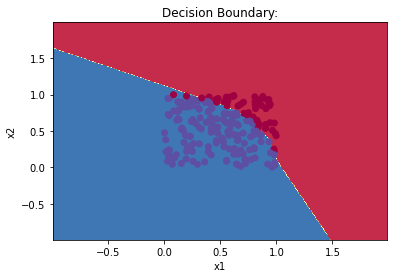

In [124]:
X, Y, X_ver, Y_ver = generate_dataset('disk')

# Build a model with a n_h-dimensional hidden layer
weights_biases = nn_model(X, Y, n_1 = 4, n_2=5, num_iterations = 100000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(weights_biases, x), X_ver.T, Y_ver.T)
plt.title("Decision Boundary:")



In [125]:
predictions = predict(weights_biases, X_ver)
print ('Accuracy: %d' % float((np.dot(Y_ver.T,predictions.T) + np.dot(1-Y_ver.T,1-predictions.T))/float(Y_ver.T.size)*100) + '%')

Accuracy: 98%


As we can see, this neural network is capable of achieving nearly $\geq98\%$ accuracy on all three datasets, including the third highly linearly non-separble one.